In [1]:
import torch
import mlp_classifier
import conv1d_classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/rmeno12/paramnet/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mlp = mlp_classifier.MLPClassifier(1033).to(device)
mlp.load_state_dict(torch.load('./models/W_MLP_512_128_32__0.86.pth'))
mlp.eval()
print(mlp)

conv = conv1d_classifier.Conv1dClassifier(1033).to(device)
conv.load_state_dict(torch.load('./models/ahgtrackmodel3.pth'))
conv.eval()
print(conv)

MLPClassifier(
  (seq): Sequential(
    (0): Linear(in_features=1033, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
Conv1dClassifier(
  (conv): Sequential(
    (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(4, 16, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [5]:
import dataset

d = dataset.CurveParamClassifierDataset(["ahgtrack2.bag", 'ahgtrack3.bag'])

mlp_wrong = []
conv_wrong = []
for i, (x, y) in enumerate(d):
    x, y = x.to(device), y.to(device)
    y_pred = torch.sigmoid(mlp(x))
    if abs(y_pred - y) > 0.1:
        mlp_wrong.append(i)

    x, y = x.to(device)[None, :], y.to(device)
    y_pred = torch.sigmoid(conv(x))
    if abs(y_pred - y) > 0.1:
        conv_wrong.append(i)


print(f"mlp got {len(mlp_wrong)} wrong, conv got {len(conv_wrong)} wrong")


Pos: 4224, Neg: 7395
mlp got 3943 wrong, conv got 872 wrong


In [6]:
mlp_fn = set()
mlp_fp = set()
for i in mlp_wrong:
    if d[i][1] == 1:
        mlp_fn.add(i)
    else:
        mlp_fp.add(i)

conv_fn = set()
conv_fp = set()
for i in conv_wrong:
    if d[i][1] == 1:
        conv_fn.add(i)
    else:
        conv_fp.add(i)

print(f"of those that mlp got wrong, {len(mlp_fn)} were false negatives and {len(mlp_fp)} were false positives")
print(f"of those that conv got wrong, {len(conv_fn)} were false negatives and {len(conv_fp)} were false positives")

of those that mlp got wrong, 3907 were false negatives and 36 were false positives
of those that conv got wrong, 402 were false negatives and 470 were false positives


In [52]:
shared_fn = mlp_fn.intersection(conv_fn)
shared_fp = mlp_fp.intersection(conv_fp)

print(f"mlp and conv both got {len(shared_fn)} false negatives and {len(shared_fp)} false positives")

mlp and conv both got 16 false negatives and 70 false positives


In [15]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# the scan is a list of ranges from a lidar
# we want to create a 2D rasterization of it
ANGLE_MIN = -2.251474
ANGLE_INC = 0.0043633
def scan_to_image(scan):
    img = np.zeros((200, 200))
    center = np.array((100, 100))
    for i in range(len(scan)):
        ang = ANGLE_MIN + i * ANGLE_INC
        x = int(center[0] + scan[i] * np.cos(ang) * 300)
        y = int(center[1] + scan[i] * np.sin(ang) * 300)
        if x >= 0 and x < 200 and y >= 0 and y < 200:
            img[x, y] = 1
    return img


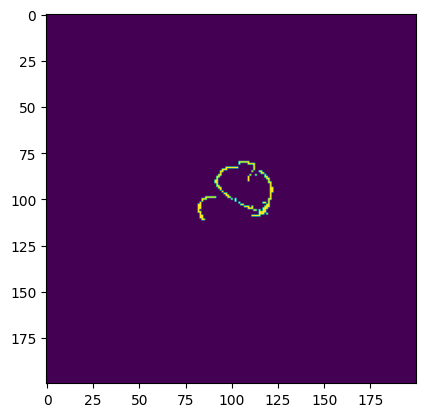

In [16]:
# print('Should have been', d[wrong[0]][1].item())
plt.imshow(scan_to_image(d[conv_wrong[200]][0]))